In [1]:
from pathlib import Path
from smpl_sim.smpllib.smpl_local_robot import SMPL_Robot
import numpy as np
import mujoco
import PIL.Image
from omegaconf import OmegaConf
from smpl_sim.envs.humanoid_env import HumanoidEnv
import mediapy as media


YAML_CONFIG_STR = """
env:
    task: HumanoidEnv
    note: this is the default config file for humanoid_env
    episode_length: 300
    sim_timestep_inv: 450
    control_frequency_inv: 15
    control_mode: "uhc_pd"
    power_scale: 1.0
    root_height_obs: true
    enable_early_termination: True
    self_obs_v: 1
    kp_scale: 1.0
    kd_scale: 1.0
    cycle_motion: False
    power_reward: True
    clip_actions: True
    contact_bodies: ["R_Ankle", "L_Ankle", "R_Toe", "L_Toe"]
    render_mode: "rgb_array"
    camera: "side"
    state_init: Default
robot:
    note: "Humanoid robot with SMPL body model."
    humanoid_type: smpl
    has_upright_start: False
    has_shape_obs: False
    has_weight_obs: False
    has_shape_variation: False
    has_mesh: False
    replace_feet: True
    has_jt_limit: False
    height_fix_mode: full
    big_ankle: True
    remove_toe: False
    real_weight_porpotion_capsules: True
    real_weight_porpotion_boxes: True
    real_weight: True
    box_body: True
    smpl_data_dir: /private/home/pirotta/PerpetualHumanoidControl-MJX/data/smpl
headless: False
"""
cfg = OmegaConf.create(YAML_CONFIG_STR)
env = HumanoidEnv(cfg)
obs, info = env.reset(seed=0)

# robot_cfg = {
#     "mesh": cfg.robot.has_mesh,
#     "replace_feet": cfg.robot.replace_feet,
#     "rel_joint_lm": cfg.robot.has_jt_limit,
#     "remove_toe": cfg.robot.get("remove_toe", False),
#     "freeze_hand": cfg.robot.get("freeze_hand", False),
#     "real_weight_porpotion_capsules": cfg.robot.real_weight_porpotion_capsules,
#     "real_weight_porpotion_boxes": cfg.robot.real_weight_porpotion_boxes,
#     "real_weight": cfg.robot.real_weight,
#     "master_range": cfg.robot.get("master_range", 30),
#     "big_ankle": cfg.robot.big_ankle,
#     "box_body": cfg.robot.box_body,
#     "masterfoot": cfg.robot.get("masterfoot", False),
#     "upright_start": cfg.robot.has_upright_start,
#     "model": cfg.robot.humanoid_type,
#     "body_params": {},
#     "joint_params": {},
#     "geom_params": {},
#     "actuator_params": {},
# }
# robot = SMPL_Robot(
#     robot_cfg,
#     data_dir=cfg.robot.smpl_data_dir,
# )

# xml = robot.export_xml_string().decode("utf-8")
# mj_model = mujoco.MjModel.from_xml_string(xml)
# mj_data = mujoco.MjData(mj_model)

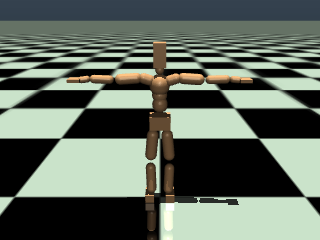

In [11]:
mj_data = env.mj_data
mj_model = env.mj_model

mj_data.qpos[:] = 0
mj_data.qvel[:] = 0
mj_data.qpos[2] = 0.94
mj_data.qpos[3:7] = np.array([0.5, 0.5, 0.5, 0.5])


sim_timestep_inv = 450
sim_timestep = 1.0 / sim_timestep_inv
control_frequency_inv = 15
mj_model.opt.timestep = sim_timestep

# setup renderer
mj_renderer = mujoco.Renderer(mj_model)
mujoco.mj_forward(mj_model, mj_data)
cam = mujoco.MjvCamera()
mujoco.mjv_defaultCamera(cam)
cam.distance, cam.azimuth, cam.elevation, cam.lookat = 3, 0, -20, mj_data.qpos[:3]
mj_renderer.update_scene(mj_data, cam)
pixels = mj_renderer.render()
PIL.Image.fromarray(pixels)


# _smpl_robot_info = {
#     "height": _smpl_robot.height.item(),
#     "gender": gender,
#     "weight": mujoco.mj_getTotalmass(mj_model),
#     "beta": beta.ravel()
# }

# for k, v in _smpl_robot_info.items():
#     print(f"{k}: {v}")


In [22]:
frames = [mj_renderer.render()]
num_steps = 10
print(mj_model.opt.timestep)
mj_model.opt.integrator = mujoco.mjtIntegrator.mjINT_RK4
for time in range(num_steps):
    action = np.random.rand(env.action_space.shape[0]) * 2 - 1
    torque = env.power_scale * env.torque_lim * action
    print(torque.min(), torque.max())
    for internal_step in range(control_frequency_inv):
        mj_data.ctrl[:] = torque
        mujoco.mj_step(mj_model, mj_data)
        if mj_data.warning.number.any():
            warning_index = np.nonzero(mj_data.warning.number)[0].item()
            print(warning_index)
            warning = mujoco.mjtWarning(warning_index).name
            print(f'stopped due to divergence ({warning}) at timestep {time}/{internal_step}.\n')

            # mj_data.qpos[:] = 0
            # mj_data.qvel[:] = 0
            # mj_data.qpos[2] = 0.94
            # mj_data.qpos[3:7] = np.array([0.5, 0.5, 0.5, 0.5])
            # mujoco.mj_forward(mj_model, mj_data)

            # break
    cam.lookat = mj_data.qpos[:3]
    mj_renderer.update_scene(mj_data, cam)
    pixels = mj_renderer.render()
    frames.append(pixels)

media.show_video(frames, fps=5)

0.0022222222222222222
-496.5120037139217 489.5430634898371
6
stopped due to divergence (mjWARN_BADQACC) at timestep 0/0.

6
stopped due to divergence (mjWARN_BADQACC) at timestep 0/1.

6
stopped due to divergence (mjWARN_BADQACC) at timestep 0/2.

6
stopped due to divergence (mjWARN_BADQACC) at timestep 0/3.

6
stopped due to divergence (mjWARN_BADQACC) at timestep 0/4.

6
stopped due to divergence (mjWARN_BADQACC) at timestep 0/5.

6
stopped due to divergence (mjWARN_BADQACC) at timestep 0/6.

6
stopped due to divergence (mjWARN_BADQACC) at timestep 0/7.

6
stopped due to divergence (mjWARN_BADQACC) at timestep 0/8.

6
stopped due to divergence (mjWARN_BADQACC) at timestep 0/9.

6
stopped due to divergence (mjWARN_BADQACC) at timestep 0/10.

6
stopped due to divergence (mjWARN_BADQACC) at timestep 0/11.

6
stopped due to divergence (mjWARN_BADQACC) at timestep 0/12.

6
stopped due to divergence (mjWARN_BADQACC) at timestep 0/13.

6
stopped due to divergence (mjWARN_BADQACC) at timeste